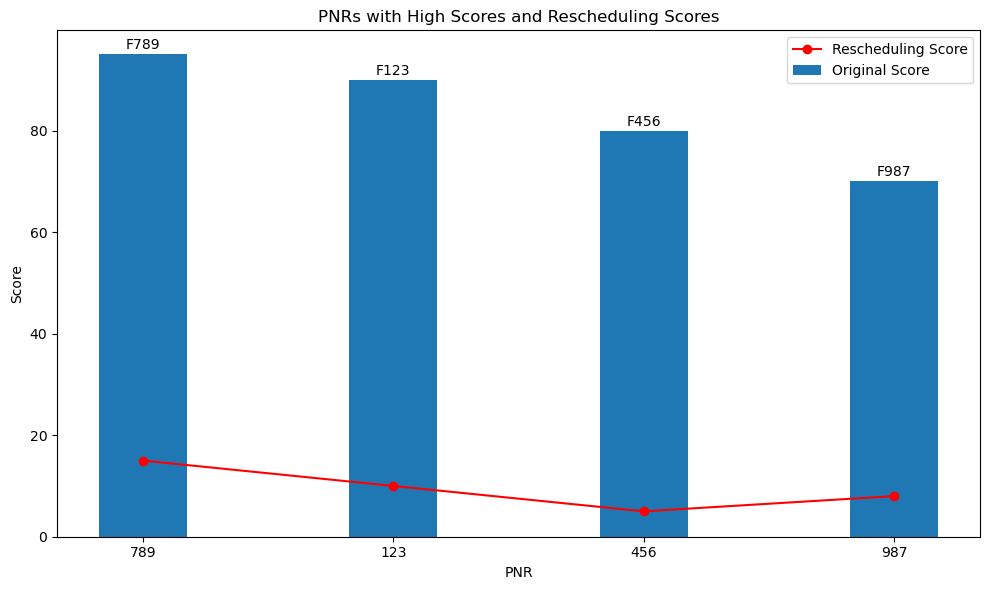

In [1]:
import matplotlib.pyplot as plt

# Assuming you have the following dictionaries
pnr_flight_dict = {123: 'F123', 456: 'F456', 789: 'F789', 987: 'F987'}
pnr_score_dict = {123: 90, 456: 80, 789: 95, 987: 70}
rescheduling_score_dict = {(123, 'F123'): 10, (456, 'F456'): 5, (789, 'F789'): 15, (987, 'F987'): 8}

# Sort the PNRS by scores
sorted_pnrs = sorted(pnr_score_dict.keys(), key=lambda x: pnr_score_dict[x], reverse=True)

# Extract flight IDs and scores for each PNR
flight_ids = [pnr_flight_dict[pnr] for pnr in sorted_pnrs]
scores = [pnr_score_dict[pnr] for pnr in sorted_pnrs]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(sorted_pnrs))

# Plotting the scores
bars1 = ax.bar(index, scores, bar_width, label='Original Score')

# Plotting the rescheduling scores as a line plot
rescheduling_scores = [rescheduling_score_dict[(pnr, pnr_flight_dict[pnr])] for pnr in sorted_pnrs]
line = ax.plot(index, rescheduling_scores, label='Rescheduling Score', marker='o', color='red')

# Adding labels and title
ax.set_xlabel('PNR')
ax.set_ylabel('Score')
ax.set_title('PNRs with High Scores and Rescheduling Scores')
ax.set_xticks(index)
ax.set_xticklabels(sorted_pnrs)
ax.legend()

# Adding flight IDs as text on top of bars
for i, score in enumerate(scores):
    ax.text(i, score + 1, pnr_flight_dict[sorted_pnrs[i]], ha='center')

# Display the plot
plt.tight_layout()
plt.show()

In [2]:
import plotly.graph_objects as go

# Assuming you have the following dictionaries
pnr_flight_dict = {123: 'F123', 456: 'F456', 789: 'F789', 987: 'F987'}
pnr_score_dict = {123: 90, 456: 80, 789: 95, 987: 70}
rescheduling_score_dict = {(123, 'F123'): 10, (456, 'F456'): 5, (789, 'F789'): 15, (987, 'F987'): 8}

# Sort the PNRS by scores
sorted_pnrs = sorted(pnr_score_dict.keys(), key=lambda x: pnr_score_dict[x], reverse=True)

# Extract flight IDs and scores for each PNR
flight_ids = [pnr_flight_dict[pnr] for pnr in sorted_pnrs]
original_scores = [pnr_score_dict[pnr] for pnr in sorted_pnrs]
rescheduling_scores = [rescheduling_score_dict[(pnr, pnr_flight_dict[pnr])] for pnr in sorted_pnrs]

# Create a bar chart
fig = go.Figure()

# Bar chart for original scores
fig.add_trace(go.Bar(x=sorted_pnrs, y=original_scores, name='Original Score'))

# Line chart for rescheduling scores
fig.add_trace(go.Scatter(x=sorted_pnrs, y=rescheduling_scores, mode='lines+markers', name='Rescheduling Score', line=dict(color='red')))

# Layout customization
fig.update_layout(
    xaxis=dict(title='PNR'),
    yaxis=dict(title='Score'),
    title='PNRs with High Scores and Rescheduling Scores',
    barmode='group'
)

# Display the plot
fig.show()
